In [1]:
import pandas as pd
import datetime as dt
import spotipy
from secrets import spotify_secrets, localhost_db, postgres_db
from sqlalchemy import create_engine
from spotipy.oauth2 import SpotifyOAuth

In [2]:
RANGES = {'short_term': 'Short', 'medium_term': 'Medium', 'long_term': 'Long'}
LIMIT = 50

def get_user_df(sp):
    user = sp.me()
    df_user = pd.DataFrame({
        'user_id': user['id'],
        'display_name': user['display_name'],
        'spotify_url': user['external_urls']['spotify'],
        'image_url': user['images'][0]['url'],
        'followers': user['followers']['total'],
        'date_created': dt.datetime.now(),
        'last_updated': dt.datetime.now()
    }, index=[0])
    return df_user

def get_top_artists_df(sp):
    user_id = sp.me()['id']
    top_list = []
    for r in RANGES:
        top_artists = sp.current_user_top_artists(time_range=r, limit=LIMIT)
        for i, a in enumerate(top_artists['items']):
            this_top = {
                'user_id': user_id,
                'rank': i+1,
                'artist_id': a['id'],
                'timeframe': RANGES[r],
                'artist': a['name'],
                'genres': "; ".join(g for g in a['genres']),
                'artist_url': a['external_urls']['spotify'],
                'artist_image': a['images'][0]['url'],
                'popularity': a['popularity'],
            }
            top_list.append(this_top)
    return pd.DataFrame.from_dict(top_list)

def get_top_tracks_df(sp):
    user_id = sp.me()['id']
    top_list = []
    for r in RANGES:
        top_tracks = sp.current_user_top_tracks(time_range=r, limit=LIMIT)
        for i, t in enumerate(top_tracks['items']):
            this_top = {
                'user_id': user_id,
                'rank': i+1,
                'track_id': t['id'],
                'timeframe': RANGES[r],
                'track_id': t['id'],
                'track': t['name'],
                'artists': "; ".join(a['name'] for a in t['artists']),
                'album': t['album']['name'],
                'album_image': t['album']['images'][0]['url'],
                'release_date': t['album']['release_date'],
                'track_url': t['external_urls']['spotify'],
                'timeframe': RANGES[r]
            }
            top_list.append(this_top)
    return pd.DataFrame.from_dict(top_list)

def get_top_genres_df(top_artists, weight=128, shift=10):
    df_genre = pd.DataFrame(columns=['user_id', 'rank', 'genre', 'points', 'timeframe'])
    user_id = top_artists['Short'][0]['user_id']
    top_genres_list = []
    for timeframe in ['Short', 'Medium', 'Long']:
        top_genres = {}
        for artist in top_artists[timeframe]:
            try:
                points = weight / ((artist['rank'] + shift) ** 2)
                genres = artist['genres'].split(';')
                for genre in genres:
                    genre = genre.strip().title()
                    if genre in top_genres:
                        top_genres[genre] += points
                    else:
                        top_genres[genre] = points
            except:
                pass
        top_genres = {k: v for k, v in sorted(top_genres.items(), key=lambda item: item[1], reverse=True)}
        genres = [g for g in list(top_genres.keys())[:LIMIT]]
        points = [p for p in list(top_genres.values())[:LIMIT]]
        user_ids = [user_id for i in range(len(top_genres))]
        ranks = [i for i in range(1, len(top_genres)+1)]
        timeframes = [timeframe for i in range(len(top_genres))]
        df_genre = df_genre.append(pd.DataFrame(list(map(list, zip(*[user_ids, ranks, genres, points, timeframes]))), \
                                                columns=['user_id', 'rank', 'genre', 'points', 'timeframe']))
    return df_genre.reset_index(drop=True)

def get_music_features_df(top_tracks):
    audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', \
                      'liveness', 'valence', 'tempo']
    df_feature = pd.DataFrame(columns=['user_id'] + audio_features + ['timeframe'])
    user_id = top_tracks['Short'][0]['user_id']
    for timeframe in ['Short', 'Medium', 'Long']:
        this_feature = {'user_id': user_id, 'timeframe': timeframe}
        all_features = sp.audio_features([t['track_id'] for t in top_tracks[timeframe]])
        for f in audio_features:
            this_feature[f] = sum(a[f] for a in all_features) / len(all_features)
        df_feature = df_feature.append(this_feature, ignore_index=True)
    return df_feature

def get_recently_played_df(sp):
    user_id = sp.me()['id']
    recently_played = sp.current_user_recently_played()
    dict_list = []
    for rp in recently_played['items']:
        this_track = {
            'user_id': user_id,
            'track': rp['track']['name'],
            'artists': "; ".join(a['name'] for a in rp['track']['artists']),
            'album': rp['track']['album']['name'],
            'release_date': rp['track']['album']['release_date'],
            'track_url': rp['track']['external_urls']['spotify'],
            'played_at': rp['played_at']
        }
        dict_list.append(this_track)
    return pd.DataFrame.from_dict(dict_list)

def get_current_playlists_df(sp):
    user_id = sp.me()['id']
    user_playlists = sp.current_user_playlists()
    dict_list = []
    for pl in user_playlists['items']:
        this_playlist = {
            'user_id': user_id,
            'playlist_id': pl['id'],
            'name': pl['name'],
            'description': pl['description'],
            'owner_display_name': pl['owner']['display_name'],
            'playlist_url': pl['external_urls']['spotify'],
            'track_numbers': pl['tracks']['total']
        }
        dict_list.append(this_playlist)
    return pd.DataFrame.from_dict(dict_list)

In [3]:
def top_to_dict(top_df):
    top_dict = {}
    top_dict['Short'] = top_df.loc[top_df['timeframe'] == 'Short'].to_dict('records')
    top_dict['Medium'] = top_df.loc[top_df['timeframe'] == 'Medium'].to_dict('records')
    top_dict['Long'] = top_df.loc[top_df['timeframe'] == 'Long'].to_dict('records')
    return top_dict

In [4]:
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=spotify_secrets["Client Id"],
                                               client_secret=spotify_secrets["Client Secret"],
                                               redirect_uri="http://localhost:8892/callback",
                                               scope="user-top-read"))

In [5]:
user = get_user_df(sp)
user.head()

,user_id,display_name,spotify_url,image_url,followers,date_created,last_updated
0,12120382831,Bin Xuan Kong,https://open.spotify.com/user/12120382831,https://scontent-hkt1-1.xx.fbcdn.net/v/t1.0-1/...,53,2021-01-05 16:01:39.106837,2021-01-05 16:01:39.106848


In [6]:
top_artists = get_top_artists_df(sp)
top_artists.head()

,user_id,rank,artist_id,timeframe,artist,genres,artist_url,artist_image,popularity
0,12120382831,1,3mIj9lX2MWuHmhNCA7LSCW,Short,The 1975,modern alternative rock; modern rock; nu gaze;...,https://open.spotify.com/artist/3mIj9lX2MWuHmh...,https://i.scdn.co/image/94dd2feca73bdfb7e1c127...,79
1,12120382831,2,2elBjNSdBE2Y3f0j1mjrql,Short,Jay Chou,c-pop; mandopop; taiwan pop; zhongguo feng,https://open.spotify.com/artist/2elBjNSdBE2Y3f...,https://i.scdn.co/image/0e5952203ea0140aa5687f...,73
2,12120382831,3,0fA0VVWsXO9YnASrzqfmYu,Short,Kid Cudi,ohio hip hop; pop rap; rap,https://open.spotify.com/artist/0fA0VVWsXO9YnA...,https://i.scdn.co/image/4cb57ae1ef87546455db9c...,90
3,12120382831,4,7CajNmpbOovFoOoasH2HaY,Short,Calvin Harris,dance pop; edm; electro house; house; pop; pop...,https://open.spotify.com/artist/7CajNmpbOovFoO...,https://i.scdn.co/image/af53b9a94b36d4d1af3908...,86
4,12120382831,5,0Riv2KnFcLZA3JSVryRg4y,Short,Hiroyuki Sawano,anime score; japanese soundtrack; otacore,https://open.spotify.com/artist/0Riv2KnFcLZA3J...,https://i.scdn.co/image/7d49d81da712574ad70809...,68


In [7]:
top_tracks = get_top_tracks_df(sp)
top_tracks.head()

,user_id,rank,track_id,timeframe,track,artists,album,album_image,release_date,track_url
0,12120382831,1,73jVPicY2G9YHmzgjk69ae,Short,Robbers,The 1975,The 1975,https://i.scdn.co/image/ab67616d0000b27304f21e...,2013-01-01,https://open.spotify.com/track/73jVPicY2G9YHmz...
1,12120382831,2,6m9qPYXmhge2QhBLfFKnVF,Short,Same Drugs,Chance the Rapper,Coloring Book,https://i.scdn.co/image/ab67616d0000b273e71dd1...,2016-05-27,https://open.spotify.com/track/6m9qPYXmhge2QhB...
2,12120382831,3,2rtGaCAeYtmcIvuZsvgTf6,Short,How to Disappear Completely,Radiohead,Kid A,https://i.scdn.co/image/ab67616d0000b273674c2b...,2000-10-02,https://open.spotify.com/track/2rtGaCAeYtmcIvu...
3,12120382831,4,4C9rhLT37Gv6VMVtFCb7O1,Short,Harvest Moon,Handsome Ghost,Harvest Moon,https://i.scdn.co/image/ab67616d0000b27300626c...,2018-01-05,https://open.spotify.com/track/4C9rhLT37Gv6VMV...
4,12120382831,5,6ilc4vQcwMPlvAHFfsTGng,Short,Sweet,Cigarettes After Sex,Cigarettes After Sex,https://i.scdn.co/image/ab67616d0000b27394d280...,2017-06-09,https://open.spotify.com/track/6ilc4vQcwMPlvAH...


In [8]:
top_genres = get_top_genres_df(top_to_dict(top_artists))
top_genres.head()

,user_id,rank,genre,points,timeframe
0,12120382831,1,Pop,4.041452,Short
1,12120382831,2,Edm,2.109535,Short
2,12120382831,3,Pop Dance,2.036973,Short
3,12120382831,4,Rap,2.002428,Short
4,12120382831,5,Dance Pop,1.410713,Short


In [9]:
music_features = get_music_features_df(top_to_dict(top_tracks))
music_features.head()

,user_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,timeframe
0,12120382831,0.52340,0.503416,-8.33806,0.035672,0.408187,0.077764,0.180582,0.341464,114.33746,Short
1,12120382831,0.49986,0.699520,-6.03542,0.054598,0.186149,0.004719,0.165754,0.439602,134.19486,Medium
2,12120382831,0.66628,0.631300,-6.53124,0.157228,0.196543,0.034440,0.166034,0.451820,124.46328,Long


In [10]:
artists = top_artists.drop(columns=['user_id', 'rank', 'timeframe']).drop_duplicates()
artists.head()

,artist_id,artist,genres,artist_url,artist_image,popularity
0,3mIj9lX2MWuHmhNCA7LSCW,The 1975,modern alternative rock; modern rock; nu gaze;...,https://open.spotify.com/artist/3mIj9lX2MWuHmh...,https://i.scdn.co/image/94dd2feca73bdfb7e1c127...,79
1,2elBjNSdBE2Y3f0j1mjrql,Jay Chou,c-pop; mandopop; taiwan pop; zhongguo feng,https://open.spotify.com/artist/2elBjNSdBE2Y3f...,https://i.scdn.co/image/0e5952203ea0140aa5687f...,73
2,0fA0VVWsXO9YnASrzqfmYu,Kid Cudi,ohio hip hop; pop rap; rap,https://open.spotify.com/artist/0fA0VVWsXO9YnA...,https://i.scdn.co/image/4cb57ae1ef87546455db9c...,90
3,7CajNmpbOovFoOoasH2HaY,Calvin Harris,dance pop; edm; electro house; house; pop; pop...,https://open.spotify.com/artist/7CajNmpbOovFoO...,https://i.scdn.co/image/af53b9a94b36d4d1af3908...,86
4,0Riv2KnFcLZA3JSVryRg4y,Hiroyuki Sawano,anime score; japanese soundtrack; otacore,https://open.spotify.com/artist/0Riv2KnFcLZA3J...,https://i.scdn.co/image/7d49d81da712574ad70809...,68


In [11]:
tracks = top_tracks.drop(columns=['user_id', 'rank', 'timeframe']).drop_duplicates()
tracks.head()

,track_id,track,artists,album,album_image,release_date,track_url
0,73jVPicY2G9YHmzgjk69ae,Robbers,The 1975,The 1975,https://i.scdn.co/image/ab67616d0000b27304f21e...,2013-01-01,https://open.spotify.com/track/73jVPicY2G9YHmz...
1,6m9qPYXmhge2QhBLfFKnVF,Same Drugs,Chance the Rapper,Coloring Book,https://i.scdn.co/image/ab67616d0000b273e71dd1...,2016-05-27,https://open.spotify.com/track/6m9qPYXmhge2QhB...
2,2rtGaCAeYtmcIvuZsvgTf6,How to Disappear Completely,Radiohead,Kid A,https://i.scdn.co/image/ab67616d0000b273674c2b...,2000-10-02,https://open.spotify.com/track/2rtGaCAeYtmcIvu...
3,4C9rhLT37Gv6VMVtFCb7O1,Harvest Moon,Handsome Ghost,Harvest Moon,https://i.scdn.co/image/ab67616d0000b27300626c...,2018-01-05,https://open.spotify.com/track/4C9rhLT37Gv6VMV...
4,6ilc4vQcwMPlvAHFfsTGng,Sweet,Cigarettes After Sex,Cigarettes After Sex,https://i.scdn.co/image/ab67616d0000b27394d280...,2017-06-09,https://open.spotify.com/track/6ilc4vQcwMPlvAH...


In [12]:
engine = create_engine(postgres_db)
user.to_sql('Users', engine, index=False, if_exists='replace')
top_artists[['user_id', 'rank', 'artist_id', 'timeframe']].to_sql('TopArtists', engine, index=False, if_exists='replace')
top_tracks[['user_id', 'rank', 'track_id', 'timeframe']].to_sql('TopTracks', engine, index=False, if_exists='replace')
top_genres.to_sql('TopGenres', engine, index=False, if_exists='replace')
music_features.to_sql('MusicFeatures', engine, index=False, if_exists='replace')
artists.to_sql('Artists', engine, index=False, if_exists='replace')
tracks.to_sql('Tracks', engine, index=False, if_exists='replace')
artists.to_sql('TempArtists', engine, index=False, if_exists='replace')
tracks.to_sql('TempTracks', engine, index=False, if_exists='replace')

In [13]:
import random

ADJECTIVES = ['good', 'bad', 'new', 'old', 'first', 'last', 'long', 'short', 'little', 'big', \
              'right', 'wrong', 'high', 'short', 'large', 'small', 'different', 'same', 'best', 'worst', \
              'easy', 'difficult', 'soft', 'hard', 'major', 'minor', 'public', 'private', 'real', 'fake', \
              'red', 'orange', 'yellow', 'green', 'blue', 'purple', 'black', 'white', 'grey', 'brown', \
              'pink', 'violet', 'indigo', 'silver', 'gold', 'teal', 'lime', 'maroon', 'olive', 'cyan']
NOUNS = ['time', 'year', 'month', 'day', 'week', 'thing', 'man', 'woman', 'boy', 'girl', \
         'world', 'life', 'eye', 'nose', 'ear', 'mouth', 'hair', 'hand', 'foot', 'leg', \
         'car', 'bus', 'bike', 'train', 'plane', 'boat', 'ship', 'tank', 'truck', 'taxi', \
         'dog', 'cat', 'mouse', 'cow', 'goat', 'horse', 'deer', 'rabbit', 'bird', 'monkey', \
         'bee', 'bear', 'chicken', 'fox', 'panda', 'frog', 'tiger', 'lion', 'duck', 'wolf']

code = random.choice(ADJECTIVES) + '-' + random.choice(NOUNS) + '-' + str(random.randint(1, 99))
code

'short-wolf-66'

In [14]:
df_profile = pd.DataFrame([['12120382831', code, True]], columns=['user_id', 'code', 'public'])
df_profile

,user_id,code,public
0,12120382831,short-wolf-66,True


In [15]:
engine = create_engine(postgres_db)
df_profile.to_sql('UserProfiles', engine, index=False, if_exists='replace')

In [16]:
engine.dispose()

In [2]:
import numpy as np
import matplotlib.pyplot as plt

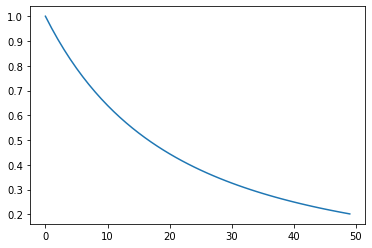

In [40]:
weight = 16
shift = 4

x = np.linspace(0, 49)
y = weight / ((0.1 * x + shift) ** 2)

plt.plot(x, y);

In [41]:
x

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49.])

In [42]:
y

array([1.        , 0.9518144 , 0.90702948, 0.86533261, 0.82644628,
       0.79012346, 0.75614367, 0.72430964, 0.69444444, 0.666389  ,
       0.64      , 0.61514802, 0.59171598, 0.56959772, 0.54869684,
       0.52892562, 0.51020408, 0.49245922, 0.47562426, 0.45963804,
       0.44444444, 0.42999194, 0.41623309, 0.40312421, 0.390625  ,
       0.37869822, 0.36730946, 0.35642682, 0.34602076, 0.33606385,
       0.32653061, 0.31739734, 0.30864198, 0.30024395, 0.29218408,
       0.28444444, 0.27700831, 0.26986001, 0.26298488, 0.25636917,
       0.25      , 0.24386526, 0.2379536 , 0.23225432, 0.22675737,
       0.22145329, 0.21633315, 0.21138856, 0.20661157, 0.2019947 ])